In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!mkdir files
!unzip /gdrive/MyDrive/코드스테이츠/개인프로젝트/section6/classified_data_v1.zip -d /content/files

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: /content/files/Normal/Normal-8608.png  
 extracting: /content/files/Normal/Normal-8609.png  
 extracting: /content/files/Normal/Normal-861.png  
 extracting: /content/files/Normal/Normal-8610.png  
 extracting: /content/files/Normal/Normal-8611.png  
 extracting: /content/files/Normal/Normal-8612.png  
 extracting: /content/files/Normal/Normal-8613.png  
 extracting: /content/files/Normal/Normal-8614.png  
 extracting: /content/files/Normal/Normal-8615.png  
 extracting: /content/files/Normal/Normal-8616.png  
 extracting: /content/files/Normal/Normal-8617.png  
 extracting: /content/files/Normal/Normal-8618.png  
 extracting: /content/files/Normal/Normal-8619.png  
 extracting: /content/files/Normal/Normal-862.png  
 extracting: /content/files/Normal/Normal-8620.png  
 extracting: /content/files/Normal/Normal-8621.png  
 extracting: /content/files/Normal/Normal-8622.png  
 extracting: /content/files/Normal/Normal-8623.png  
 extracting:

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [ ]:
import tensorflow as tf
import numpy as np 

##모델 불러오기

from keras.models import load_model
loaded_model = load_model('/gdrive/MyDrive/코드스테이츠/개인프로젝트/section6/Xray_classification_model_first.h5')

##모델 사용하기

# new_predictions = loaded_model.predict_classes(test_data)
# new_predictions = new_predictions.reshape(1,-1)[0]
# new_predictions

In [ ]:
## prediction

func_model = loaded_model
image = cv2.imread('/content/files/Viral_Pneumonia/Viral Pneumonia-1074.png')
image = cv2.resize(image, (244, 244))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = func_model.predict(image) 
i = np.argmax(preds[0])

In [ ]:
#예측 클래스
i

1

In [ ]:
for idx in range(len(func_model.layers)):
  print(func_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

batch_normalization_408
conv2d_412
max_pooling2d_14
conv2d_413
max_pooling2d_15
dropout_6
conv2d_414
max_pooling2d_16
dropout_7
conv2d_415
max_pooling2d_17
dropout_8
flatten_2
dense_4
dropout_9
dense_5


In [ ]:
func_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_408 (Bat (None, 244, 244, 3)       12        
_________________________________________________________________
conv2d_412 (Conv2D)          (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_413 (Conv2D)          (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 57, 57, 128)      

In [ ]:
icam = GradCAM(func_model, i, 'conv2d_415') 
#icam = GradCAM(func_model, i, 'dropout_8')
#icam = GradCAM(func_model, i, 'max_pooling2d_17')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/files/Viral_Pneumonia/Viral Pneumonia-1074.png')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)


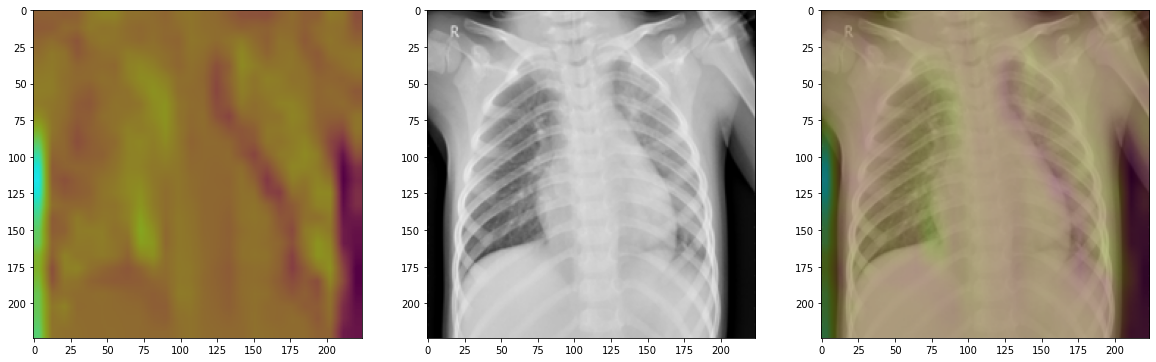

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)